# Perkenalan


   ==============================================
   
   Milestone 2

    Nama  : Nugroho Wicaksono
    Batch : FTDS-029

    Proyek ini bertujuan untuk membangun model deep learning menggunakan CNN (Convolutional Neural Networks) untuk proyek Computer Vision klasifikasi gambar dengan menggunakan dataset klasifikasi jenis kulit muka (oily, normal, atau dry). Dataset yang digunakan dalam proyek ini akan berisi data berlabel untuk kulit berminyak (oily), normal, dan kering (dry). 
    
   ==============================================

# Problem Statement


Kulit manusia memiliki berbagai jenis, seperti:

- **Berminyak (oily)**
- **Kering (dry)**
- **Normal**

Masing-masing jenis kulit memerlukan perawatan dan produk skincare yang berbeda. Namun, banyak orang kesulitan mengidentifikasi jenis kulit mereka secara akurat, yang dapat menyebabkan:

- Penggunaan produk yang tidak sesuai
- Permasalahan kulit lanjutan

Saat ini, identifikasi jenis kulit umumnya dilakukan secara manual oleh ahli kecantikan atau melalui kuesioner, yang bersifat subjektif dan kurang efisien dalam skala besar.

### Solusi yang Diajukan

Diperlukan sistem otomatis berbasis **deep learning (computer vision)** yang dapat:

- Mendeteksi jenis kulit dari gambar wajah/kulit
- Mengklasifikasikan ke dalam tiga kategori: **oily**, **dry**, dan **normal**

Model ini akan dikembangkan menggunakan **Oily, Dry, and Normal Skin Types Dataset** dan diharapkan mampu:

- Meningkatkan akurasi deteksi jenis kulit
- Mempermudah identifikasi mandiri tanpa pemeriksaan manual

---

## Target Pengguna

1. **Individu Umum**  
   Ingin mengetahui jenis kulit mereka secara akurat untuk memilih produk skincare yang sesuai.

2. **Dokter dan Terapis Kecantikan**  
   Membantu skrining cepat jenis kulit pasien tanpa inspeksi manual yang subjektif.

3. **Perusahaan Skincare**  
   Digunakan dalam:
   - Kios interaktif
   - Skin analysis booth
   - Aplikasi pemesanan produk  
   Untuk merekomendasikan produk sesuai jenis kulit pengguna.





# Import Libraries

In [1]:

import os, shutil
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all messages, 1 = info, 2 = warning, 3 = error only
logging.getLogger("tensorflow").setLevel(logging.ERROR)

Aku menggunakan kode ini untuk mengurangi verbositas (jumlah pesan) dari log TensorFlow. Secara spesifik:

- os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' memberitahu TensorFlow agar hanya menampilkan pesan berlevel error dari bagian backend C++-nya. Ini menyembunyikan pesan info dan warning.

- logging.getLogger("tensorflow").setLevel(logging.ERROR) melakukan hal serupa untuk sistem logging Python yang digunakan oleh TensorFlow, memastikan hanya pesan berlevel error yang muncul

In [2]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

f:\miniconda3\envs\tf-gpu\lib\site-packages\requests\__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


Num GPUs Available: 1


Kode ini berfungsi untuk memverifikasi apakah TensorFlow dapat mendeteksi dan mengakses GPU pada sistem serta berapa banyak GPU yang tersedia. 

In [3]:
# Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image
from skimage.color import rgb2gray
from skimage.feature import local_binary_pattern
from matplotlib.colors import rgb_to_hsv

# Model & arsitektur
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall


from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import warnings
warnings.filterwarnings('ignore')



from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras import backend as K

In [4]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

Kode ini digunakan untuk mengoptimalkan penggunaan memori GPU oleh TensorFlow. Dengan mengaktifkan memory growth, TensorFlow akan menggunakan memori GPU secara efisien, hanya mengalokasikan sebanyak yang diperlukan. 

# Data Loading

In [5]:
# Define path

main_path = 'Oily-Dry-Skin-Types'
train_path = os.path.join(main_path, 'train')
test_path = os.path.join(main_path, 'test')
valid_path = os.path.join(main_path, 'valid')

In [6]:
test_path

'Oily-Dry-Skin-Types\\test'

Kode ini digunakan untuk mendefinisikan dan mengorganisir jalur (path) ke direktori data yang akan digunakan untuk pelatihan, pengujian, dan validasi model.

In [7]:
# Check how many data in `train_path` and `test_path`

def check_path(path):
  labels = os.listdir(path)
  for label in labels:
    num_data = len(os.listdir(os.path.join(path, label)))
    print(f'Total Data - {label} : {num_data}')

print('Train Path')
check_path(train_path)
print('')

print('Test Path')
check_path(test_path)
print('')

print('valid Path')
check_path(valid_path)
print('')

Train Path
Total Data - dry : 652
Total Data - normal : 1104
Total Data - oily : 1000

Test Path
Total Data - dry : 35
Total Data - normal : 59
Total Data - oily : 40

valid Path
Total Data - dry : 71
Total Data - normal : 111
Total Data - oily : 80



Kode ini dirancang untuk menghitung dan menampilkan jumlah data (gambar) dalam setiap sub-kategori (label) di dalam direktori train, test, dan valid. Ini penting untuk memahami distribusi dataset

In [8]:
def count_images(directory):
    return sum(len(files) for _, _, files in os.walk(directory))

# Hitung jumlah gambar
train_count = count_images(train_path)
valid_count = count_images(valid_path)
test_count = count_images(test_path)
total = train_count + valid_count + test_count

# Buat ringkasan persentase
summary = pd.DataFrame({
    'Set': ['Train', 'Validation', 'Test'],
    'Persentase (%)': [
        round(train_count / total * 100, 2),
        round(valid_count / total * 100, 2),
        round(test_count / total * 100, 2)
    ]
})

print(summary)

          Set  Persentase (%)
0       Train           87.44
1  Validation            8.31
2        Test            4.25


Kode ini digunakan untuk mendapatkan gambaran statistik tentang distribusi data di antara set pelatihan, validasi, dan pengujian. Ini penting untuk:

- Memastikan bahwa data telah dibagi dengan proporsi yang wajar.

- Mengidentifikasi potensi ketidakseimbangan yang mungkin mempengaruhi pelatihan model.

- Sebagai bagian dari eksplorasi data awal dalam proyek machine learning

setelah diperiksa, ternyata val dan test set sangat imbalance maka selanjutnya akan dilakukan split (meskipun sudah ada valid dan test set folder)

In [9]:
class_names = sorted([
    name for name in os.listdir(train_path)
    if os.path.isdir(os.path.join(train_path, name))
])

print(class_names)

['dry', 'normal', 'oily']


Kode ini digunakan untuk mengidentifikasi dan mendapatkan daftar nama-nama kelas (kategori) yang ada dalam dataset pelatihan, diurutkan secara alfabetis. Nama-nama kelas ini biasanya sesuai dengan nama sub-direktori yang berisi gambar-gambar untuk setiap kategori.

In [10]:
dir_dict = {
    train_path: "train",
    test_path: "test",
    valid_path: "valid"
}

In [11]:
data = []

for type_dir, type_label in dir_dict.items():
    for class_name in class_names:
        target_folder = os.path.join(type_dir, class_name)
        for image_file in os.listdir(target_folder):
            img_path = os.path.join(target_folder, image_file)
            with Image.open(img_path) as img:
                data.append({
                    'Class_Name': class_name,
                    'Type': type_label,
                    'Img_Path': img_path,
                    'Shapes': img.size + (len(img.getbands()),)
                })

# Convert ke DataFrame
df = pd.DataFrame(data)
df.head()

,Class_Name,Type,Img_Path,Shapes
0,dry,train,Oily-Dry-Skin-Types\train\dry\dry_003e3600c061...,"(640, 640, 3)"
1,dry,train,Oily-Dry-Skin-Types\train\dry\dry_003e3600c061...,"(640, 640, 3)"
2,dry,train,Oily-Dry-Skin-Types\train\dry\dry_003e3600c061...,"(640, 640, 3)"
3,dry,train,Oily-Dry-Skin-Types\train\dry\dry_00f1189752d6...,"(640, 640, 3)"
4,dry,train,Oily-Dry-Skin-Types\train\dry\dry_00f1189752d6...,"(640, 640, 3)"


Kode ini digunakan untuk mengumpulkan metadata dari setiap gambar dalam dataset (pelatihan, pengujian, validasi). Metadata yang dikumpulkan meliputi nama kelas, jenis set data (train/test/valid), jalur lengkap gambar, dan dimensi (ukuran dan jumlah channel) dari gambar tersebut. Data ini kemudian distrukturkan menjadi Pandas DataFrame untuk analisis lebih lanjut.

In [12]:

# Split stratified (biarkan Class_Name jadi label string)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Class_Name'], random_state=44)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['Class_Name'], random_state=44)

print('Train:', train_df['Class_Name'].value_counts())
print('Val:', val_df['Class_Name'].value_counts())
print('Test:', test_df['Class_Name'].value_counts())



Train: Class_Name
normal    892
oily      784
dry       530
Name: count, dtype: int64
Val: Class_Name
normal    191
oily      168
dry       114
Name: count, dtype: int64
Test: Class_Name
normal    191
oily      168
dry       114
Name: count, dtype: int64


melakukan pembagian dataset awal secara stratified menjadi set pelatihan **(train_df)**, validasi **(val_df)**, dan pengujian **(test_df)**. Pembagian stratified memastikan bahwa proporsi kelas dalam setiap set data tetap terjaga seperti pada dataset aslinya.Pembagian stratified sangat penting dalam klasifikasi untuk:

- Mencegah bias: Memastikan bahwa model tidak melatih atau mengevaluasi kinerja hanya pada sebagian kecil dari kelas tertentu, terutama untuk kelas minoritas.

- Meningkatkan generalisasi: Memungkinkan model untuk belajar dari representasi kelas yang seimbang di set pelatihan dan dievaluasi secara adil di set validasi dan pengujian.

- Reproduktifitas: Penggunaan random_state memastikan bahwa hasil pembagian data akan konsisten setiap kali kode dijalankan.

In [13]:
# DataFrame class name 
df['Class_Name'].value_counts(normalize=True)

Class_Name
normal    0.404188
oily      0.355330
dry       0.240482
Name: proportion, dtype: float64

menghitung dan menampilkan proporsi (persentase relatif) dari setiap kelas unik dalam kolom 'Class_Name' dari DataFrame df. Ini memberikan gambaran tentang distribusi kelas secara keseluruhan dalam dataset.

# Exploratory Data Analysis (EDA)

## 1. Distribusi Class pada Dataset

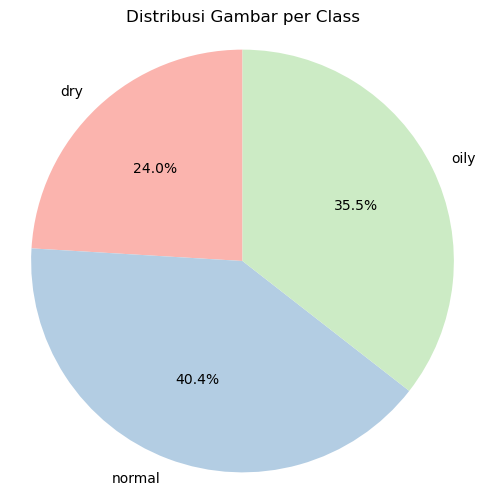

,proportion
Class_Name,
normal,0.404188
oily,0.355330
dry,0.240482


In [14]:
# Hitung jumlah gambar per class
class_counts = df['Class_Name'].value_counts().sort_index()

# Pie chart
plt.figure(figsize=(6, 6))
plt.pie(class_counts, labels=class_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Pastel1.colors)
plt.title('Distribusi Gambar per Class')
plt.axis('equal')  # Membuat pie chart jadi bulat sempurna
plt.show()

label = pd.DataFrame(df['Class_Name'].value_counts(normalize=True))
label

insight: 

Dari pie chart dan tabel proporsi, kita mendapatkan insight kunci sebagai berikut:

- Mayoritas Data adalah Kelas 'Normal': Sebanyak 40.4% dari gambar berada dalam kategori 'normal'. Ini menunjukkan bahwa dataset Anda memiliki banyak contoh untuk kelas ini, yang umumnya bagus untuk melatih model, karena model akan memiliki banyak variasi untuk dipelajari.

- Kelas 'Oily' Cukup Signifikan: Dengan 35.5% dari data, kelas 'oily' juga memiliki representasi yang kuat. Ini mendekati jumlah data 'normal', yang berarti model juga akan memiliki cukup banyak contoh untuk belajar mengenali karakteristik 'oily'.

- Kelas 'Dry' adalah Kelas Minoritas yang Jelas: Hanya 24.0% dari data termasuk dalam kategori 'dry'. Ini adalah kelas minoritas yang signifikan dibandingkan dengan 'normal' dan 'oily'.

Implikasi dari Insight:

- Potensi Bias Model: Ketidakseimbangan ini sangat mungkin menyebabkan model pembelajaran mesin menjadi bias terhadap kelas mayoritas ('normal' dan 'oily'). Model mungkin akan belajar untuk memprediksi 'normal' atau 'oily' dengan akurasi tinggi hanya karena mereka lebih sering muncul, sementara kinerja prediksi untuk kelas 'dry' bisa jadi buruk.

- Akurasi Menipu: Jika Anda hanya melihat akurasi keseluruhan (overall accuracy), mungkin terlihat tinggi (misalnya, 80-90%), tetapi ini bisa menipu. Akurasi tinggi ini mungkin hanya mencerminkan kemampuan model untuk memprediksi kelas mayoritas dengan baik, sementara ia gagal total dalam mengidentifikasi kelas 'dry'.

Cara Penanggulangan Ketidakseimbangan Kelas (Class Imbalance)

Ada beberapa strategi yang dapat diterapkan untuk mengatasi masalah ketidakseimbangan kelas ini. Pilihan terbaik seringkali bergantung pada ukuran dataset, jenis masalah, dan sumber daya komputasi.

1. Resampling Teknik (Data-level Approaches)
2. Cost-Sensitive Learning (Algorithm-level Approaches)
3. Ensemble Methods


## 2. Tampilkan Gambar dari masing masing Class

In [15]:
# Function to visualize the first 5 images from each class

def plot_images(path):
  labels = os.listdir(path)
  for label in labels:
    folder_path = os.path.join(path, label)
    fig = plt.figure(figsize=(12, 5))
    columns = 5
    rows = 1
    print('Class : ', label)
    images = os.listdir(folder_path)
    for index in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, index)
        image = plt.imread(os.path.join(folder_path, images[index]))
        plt.imshow(image)
        plt.axis("off")
    plt.show()

Class :  dry


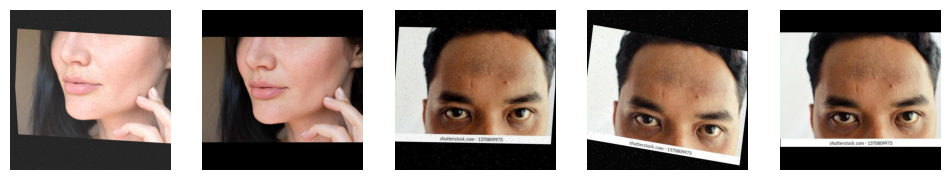

Class :  normal


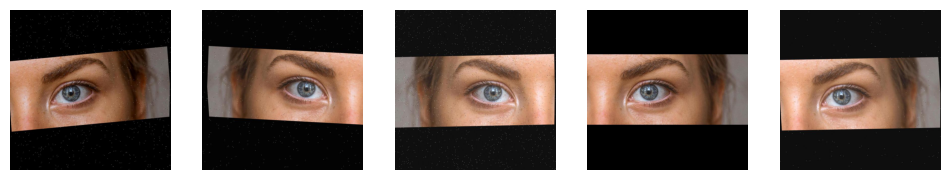

Class :  oily


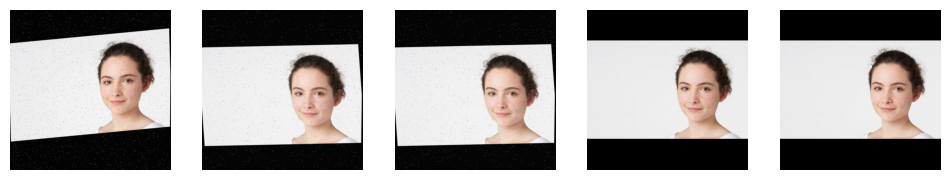

In [16]:
# Visualization of train_path

plot_images(train_path)

Variasi dalam Setiap Kelas:

- Class: dry: Gambar-gambar menunjukkan subjek dengan kulit kering. Ada variasi dalam pose, pencahayaan, dan latar belakang. Beberapa gambar juga menunjukkan cropping atau data augmentation seperti rotasi atau shifting (misalnya, terlihat pada gambar kedua dan keempat dari kiri di baris 'dry' yang terpotong secara horizontal).

- Class: normal: Gambar-gambar untuk kelas 'normal' juga menunjukkan variasi yang serupa dalam pose dan cropping.

- Class: oily: Begitu pula, kelas 'oily' menampilkan variasi pada individu dan posisi wajah.

Kualitas dan Karakteristik Gambar:

- Gambar-gambar terlihat seperti hasil dari proses preprocessing atau data augmentation (terutama yang terpotong atau sedikit miring). Ini menunjukkan bahwa dataset mungkin telah melalui tahap persiapan untuk meningkatkan variasi dan generalisasi model.

- Ada blok hitam horizontal yang muncul di beberapa gambar, yang bisa jadi merupakan artefak dari data augmentation (misalnya, rotasi yang membuat bagian kosong diisi dengan warna hitam) atau cropping yang tidak sempurna

## 3. Distribusi Resolusi Gambar Dari Masing masing Class

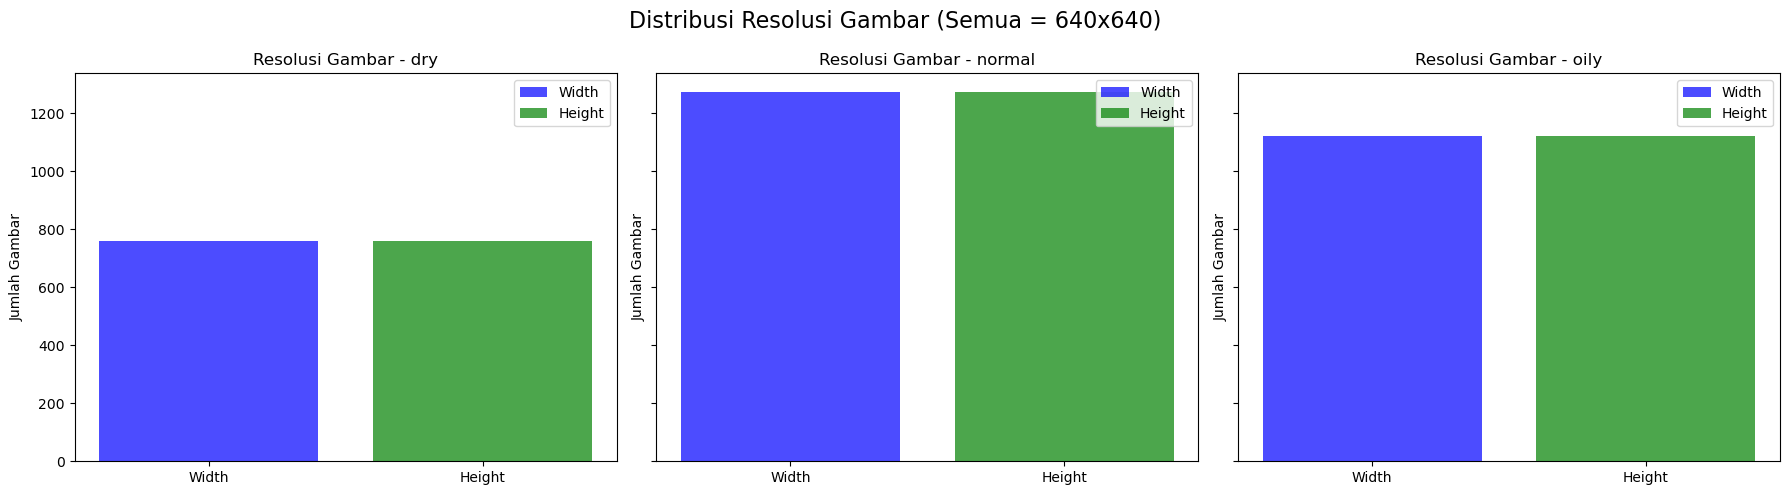

In [17]:
# Pastikan kolom 'Width' dan 'Height' sudah tersedia dari kolom 'Shapes'
if 'Width' not in df.columns or 'Height' not in df.columns:
    df['Height'] = df['Shapes'].apply(lambda x: x[0])
    df['Width'] = df['Shapes'].apply(lambda x: x[1])

# Ambil class unik
classes = sorted(df['Class_Name'].unique())

# Siapkan subplot untuk masing-masing class
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, class_name in enumerate(classes):
    class_df = df[df['Class_Name'] == class_name]

    # Hitung jumlah Width & Height (karena resolusi fix, semua pasti 640)
    width_count = class_df['Width'].value_counts()
    height_count = class_df['Height'].value_counts()

    # Plot manual sebagai bar chart
    axes[i].bar(['Width'], [width_count.iloc[0]], color='blue', label='Width', alpha=0.7)
    axes[i].bar(['Height'], [height_count.iloc[0]], color='green', label='Height', alpha=0.7)

    axes[i].set_title(f'Resolusi Gambar - {class_name}')
    axes[i].set_ylabel('Jumlah Gambar')
    axes[i].legend()

plt.suptitle('Distribusi Resolusi Gambar (Semua = 640x640)', fontsize=16)
plt.tight_layout()
plt.show()




In [18]:
df['Resolution'] = df['Width'].astype(str) + 'x' + df['Height'].astype(str)
df_summary = df.groupby(['Class_Name', 'Resolution']).size().reset_index(name='Jumlah_Gambar').sort_values(by='Jumlah_Gambar', ascending=False)
print(df_summary)


  Class_Name Resolution  Jumlah_Gambar
1     normal    640x640           1274
2       oily    640x640           1120
0        dry    640x640            758


Insight 
1. Resolusi Gambar Seragam:

- Grafik batang untuk "Resolusi Gambar - dry", "Resolusi Gambar - normal", dan "Resolusi Gambar - oily" menunjukkan bahwa baik width (lebar) maupun height (tinggi) gambar memiliki nilai yang konsisten dan tinggi (di sekitar 700-800 unit pada sumbu Y untuk dry, dan di atas 1000 unit untuk normal dan oily).

- Tabel ringkasan df_summary secara eksplisit mengkonfirmasi ini: semua gambar memiliki resolusi 640x640.

2. Jumlah Gambar per Kelas (diperkuat oleh Resolusi):

- Meskipun grafik batang tidak menunjukkan jumlah gambar secara langsung, tinggi bar menunjukkan bahwa kelas 'normal' dan 'oily' memiliki jumlah gambar yang jauh lebih banyak daripada kelas 'dry'. Ini konsisten dengan insight dari pie chart sebelumnya.

- Tabel df_summary memberikan angka pasti:

        - Normal: 1274 gambar

        - Oily: 1120 gambar

        - Dry: 758 gambar

Implikasi
1. Preprocessing yang Konsisten: Fakta bahwa semua gambar memiliki resolusi 640x640 adalah implikasi positif yang sangat kuat. Ini menunjukkan bahwa:

- Data telah di-resize secara konsisten: Ini adalah langkah preprocessing yang sangat baik dan krusial dalam computer vision. Model pembelajaran mesin (terutama Convolutional Neural Networks / CNNs) memerlukan input gambar dengan ukuran yang seragam.

- Mempermudah Pemodelan: Tidak perlu lagi melakukan resize dinamis selama pelatihan, yang dapat menghemat waktu dan sumber daya komputasi.

- Kompatibilitas Model: Resolusi 640x640 adalah ukuran yang cukup umum dan baik untuk banyak arsitektur CNN modern, memungkinkan model untuk menangkap detail yang relevan tanpa terlalu besar (yang bisa boros komputasi) atau terlalu kecil (yang bisa menghilangkan informasi).

## 4. Distribusi RGB

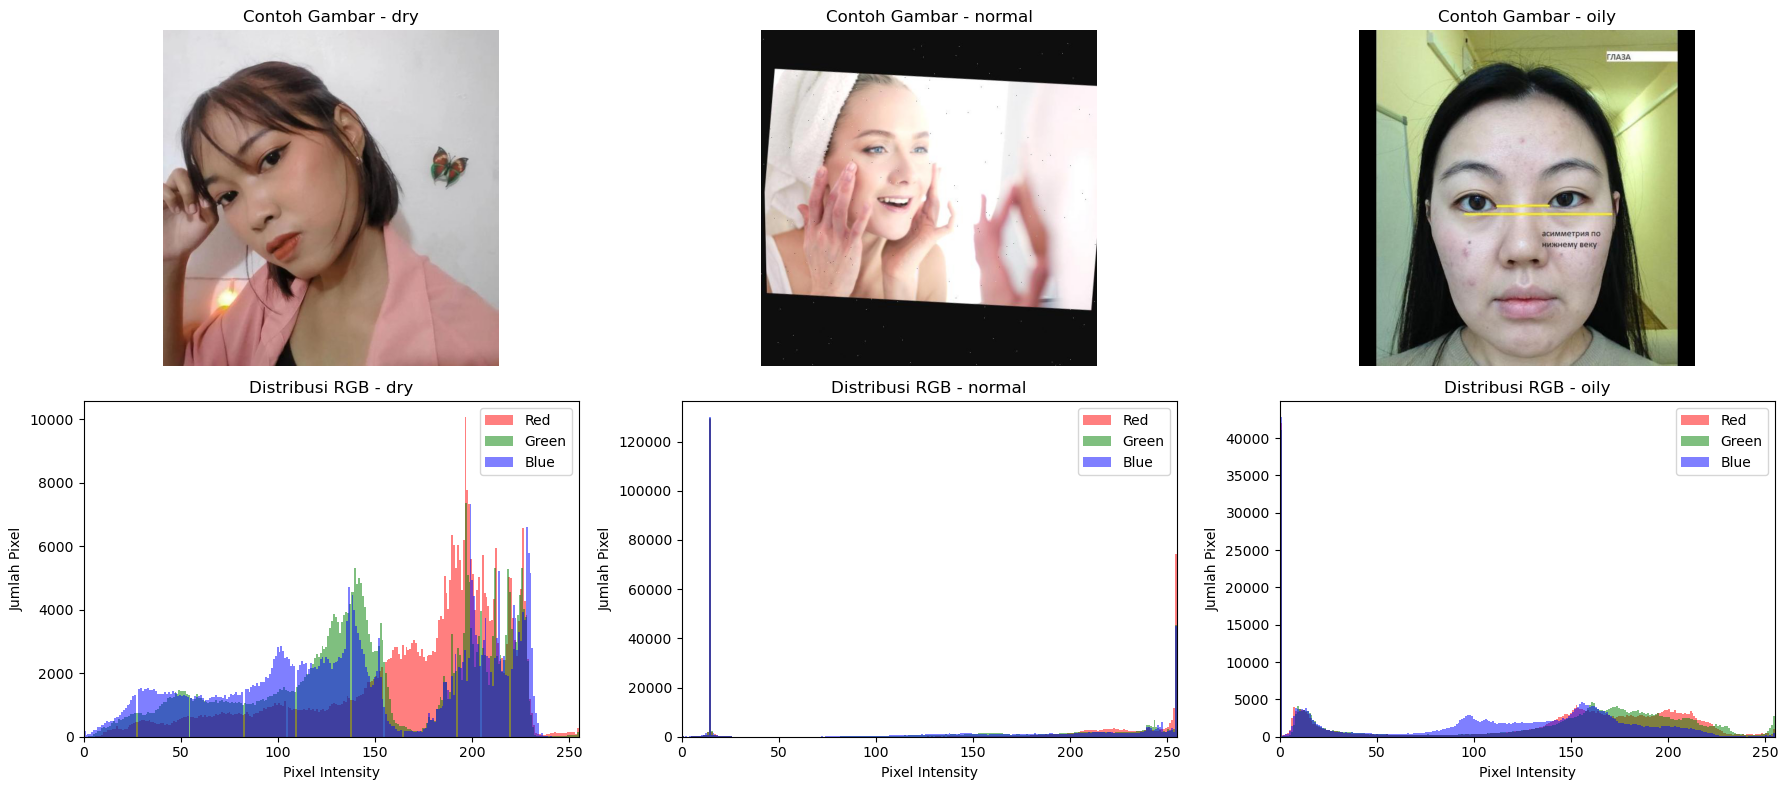

In [19]:
# Ambil nama-nama class
classes = sorted(df['Class_Name'].unique())

# Siapkan figure
fig, axes = plt.subplots(2, 3, figsize=(18, 8))  # 2 baris: gambar + RGB, 3 kolom untuk tiap class

# Loop setiap class
for i, class_name in enumerate(classes):
    # Ambil satu baris acak dari df berdasarkan class
    sample_row = df[df['Class_Name'] == class_name].sample(1, random_state=44).iloc[0]
    img_path = sample_row['Img_Path']
    
    # Buka gambar
    img = Image.open(img_path).convert('RGB')  # pastikan RGB
    img_np = np.array(img)
    
    # Tampilkan gambar
    axes[0, i].imshow(img_np)
    axes[0, i].set_title(f'Contoh Gambar - {class_name}')
    axes[0, i].axis('off')
    
    # Ambil channel RGB
    red_channel = img_np[:, :, 0].flatten()
    green_channel = img_np[:, :, 1].flatten()
    blue_channel = img_np[:, :, 2].flatten()
    
    # Plot histogram RGB
    axes[1, i].hist(red_channel, bins=256, color='red', alpha=0.5, label='Red')
    axes[1, i].hist(green_channel, bins=256, color='green', alpha=0.5, label='Green')
    axes[1, i].hist(blue_channel, bins=256, color='blue', alpha=0.5, label='Blue')
    
    axes[1, i].set_title(f'Distribusi RGB - {class_name}')
    axes[1, i].set_xlim(0, 255)
    axes[1, i].set_xlabel('Pixel Intensity')
    axes[1, i].set_ylabel('Jumlah Pixel')
    axes[1, i].legend()

plt.tight_layout()
plt.show()

## Analisis Histogram per Kelas

### 1. Kelas 'dry'
- Distribusi intensitas piksel **lebih luas**.
- Terdapat kecenderungan ke arah **nada merah/hangat**.
- Mengindikasikan karakteristik visual dari **kulit kering**.

### 2. Kelas 'normal'
- Didominasi oleh **puncak tinggi pada intensitas rendah (~0)**.
- Hal ini disebabkan oleh **artefak area hitam** dari proses augmentasi.
- Distribusi ini **tidak mencerminkan karakteristik asli kulit normal**.

### 3. Kelas 'oily'
- Memiliki distribusi yang **lebih menyebar**.
- Menunjukkan adanya variasi dalam **kecerahan atau kilau kulit**.
- Cenderung mencerminkan **reflektivitas/kilauan** pada kulit berminyak.

---

## Implikasi Penting

- Terdapat **perbedaan karakteristik warna** yang dapat dikenali antara kelas `'dry'` dan `'oily'`.
- Distribusi warna pada kelas `'normal'` **terganggu oleh artefak**, sehingga kurang dapat diandalkan untuk analisis eksplorasi berbasis warna.
- Informasi dari histogram dapat membantu **model mempelajari ciri visual** yang membedakan masing-masing kelas, selama data bebas dari artefak.


## 5. Analisis Tekstur dari Gambar Masing masing Class

### Analisis menggunakan LBP (Local Binary Pattern)

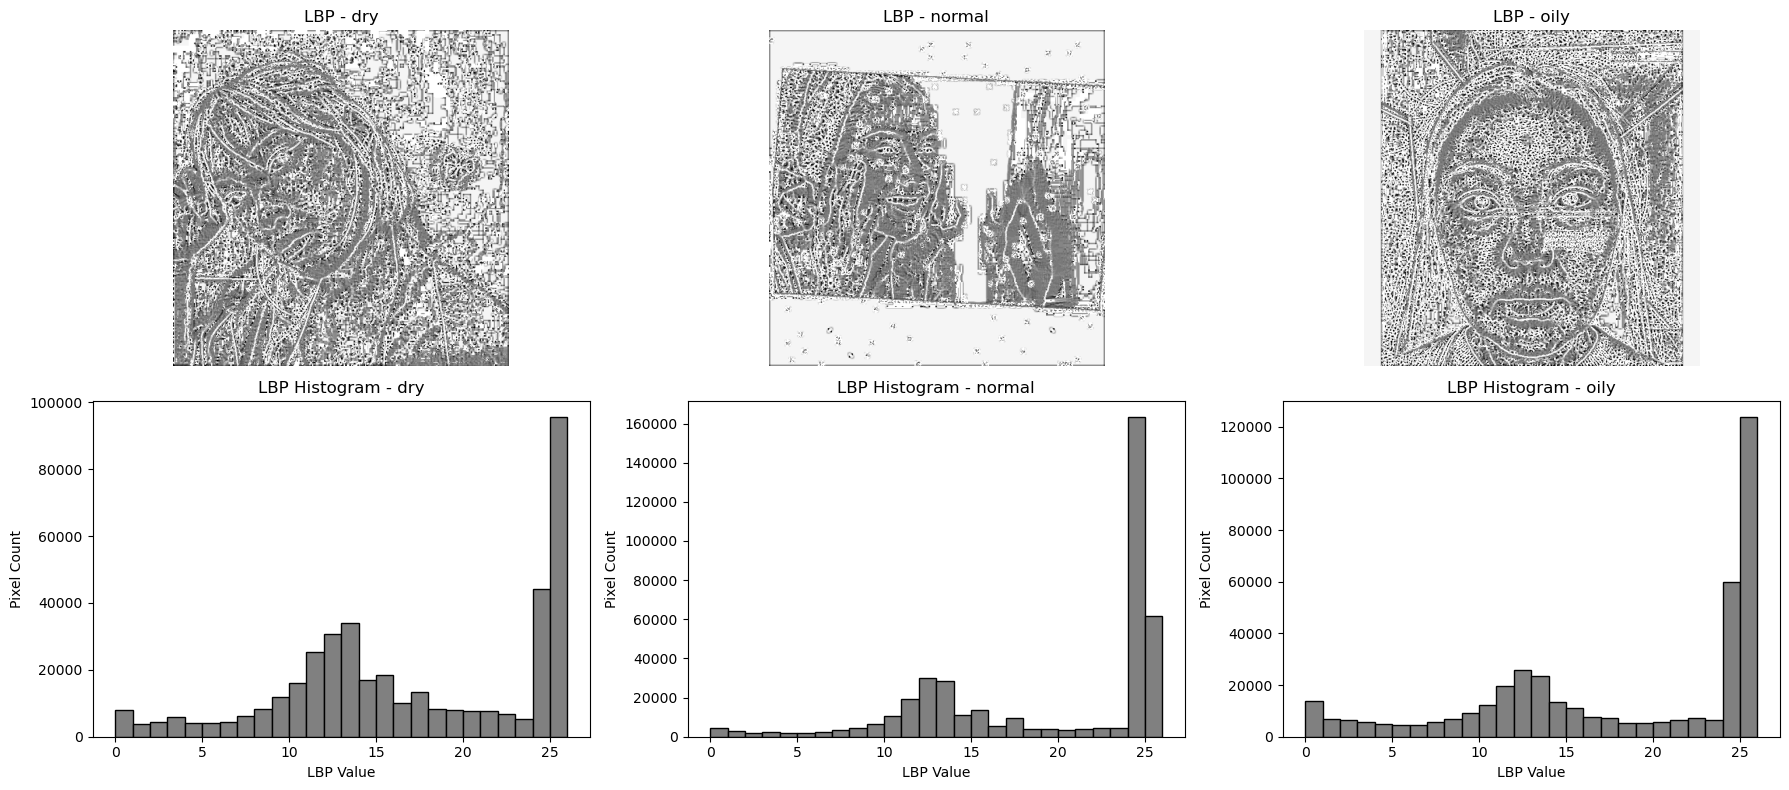

In [20]:
# Parameter LBP
radius = 3
n_points = 8 * radius
method = 'uniform'

# Ambil class unik
classes = sorted(df['Class_Name'].unique())

# Siapkan figure
fig, axes = plt.subplots(2, 3, figsize=(18, 8))  # baris 1: LBP image, baris 2: histogram

for i, class_name in enumerate(classes):
    # Ambil 1 gambar acak dari class (dengan random_state=44)
    sample_row = df[df['Class_Name'] == class_name].sample(1, random_state=44).iloc[0]
    img_path = sample_row['Img_Path']

    # Buka & convert to grayscale
    img = Image.open(img_path).convert('RGB')
    gray = rgb2gray(np.array(img))  # convert to grayscale float [0, 1]

    # Hitung LBP
    lbp = local_binary_pattern(gray, n_points, radius, method)

    # Plot LBP Image
    axes[0, i].imshow(lbp, cmap='gray')
    axes[0, i].set_title(f'LBP - {class_name}')
    axes[0, i].axis('off')

    # Plot Histogram LBP
    n_bins = int(lbp.max() + 1)
    axes[1, i].hist(lbp.ravel(), bins=n_bins, range=(0, n_bins), color='gray', edgecolor='black')
    axes[1, i].set_title(f'LBP Histogram - {class_name}')
    axes[1, i].set_xlabel('LBP Value')
    axes[1, i].set_ylabel('Pixel Count')

plt.tight_layout()
plt.show()

## Insight Utama

Gambar tersebut menampilkan hasil penerapan Local Binary Pattern (LBP) pada citra wajah yang diklasifikasikan berdasarkan jenis kulit (kering, normal, dan berminyak), serta histogram LBP yang sesuai untuk setiap jenis kulit.

### Citra LBP
Setiap citra LBP (baris atas) menunjukkan pola tekstur mikro dari wajah. LBP mengubah citra menjadi representasi tekstur lokal, di mana setiap piksel diganti dengan nilai biner yang merepresentasikan hubungan antara piksel pusat dan tetangganya.

Pada citra LBP, terlihat bahwa pola tekstur berbeda untuk setiap jenis kulit. Misalnya, citra untuk "LBP - oily" tampak memiliki pola biner yang lebih padat atau "berbutir" dibandingkan dengan "LBP - dry" atau "LBP - normal," yang bisa mengindikasikan perbedaan tekstur pori-pori atau kadar minyak pada kulit.

### Histogram LBP
Histogram LBP (baris bawah) adalah distribusi frekuensi dari nilai-nilai LBP yang muncul pada citra. Ini memberikan ringkasan kuantitatif dari tekstur global pada citra.

- **LBP Histogram - dry**: Menunjukkan distribusi nilai LBP yang cenderung lebih merata dengan beberapa puncak, mengindikasikan variasi tekstur yang mungkin tidak terlalu ekstrem.

- **LBP Histogram - normal**: Menunjukkan pola distribusi yang berbeda dari kulit kering, mungkin dengan puncak yang lebih jelas pada nilai-nilai LBP tertentu.

- **LBP Histogram - oily**: Menariknya, histogram untuk kulit berminyak menunjukkan puncak yang sangat tinggi pada nilai LBP yang mendekati 25 (atau nilai maksimum LBP yang mungkin dalam konteks ini). Ini menunjukkan bahwa ada frekuensi yang sangat tinggi dari pola tekstur tertentu yang khas untuk kulit berminyak. Puncak lainnya juga terlihat, tetapi dominasi pada nilai ekstrem ini sangat mencolok.

---

## Implikasi

### Potensi untuk Klasifikasi Jenis Kulit Otomatis
Perbedaan yang jelas dalam histogram LBP, terutama puncaknya pada nilai LBP tertentu untuk kulit berminyak, mengindikasikan bahwa fitur LBP sangat menjanjikan untuk membedakan antara berbagai jenis kulit. Ini dapat digunakan sebagai fitur input untuk algoritma klasifikasi machine learning (misalnya, Support Vector Machine, Random Forest, atau Neural Network) untuk secara otomatis mengidentifikasi jenis kulit seseorang berdasarkan citra wajahnya.

### Karakteristik Tekstur Khas untuk Setiap Jenis Kulit

- **Kulit Berminyak**: Puncak yang dominan pada histogram LBP untuk kulit berminyak menyiratkan bahwa kulit berminyak memiliki pola tekstur mikro yang sangat spesifik dan sering terjadi. Ini mungkin terkait dengan ukuran pori-pori yang lebih besar, produksi sebum yang berlebihan, atau refleksi cahaya yang berbeda pada permukaan kulit.

- **Kulit Kering dan Normal**: Histogram untuk kulit kering dan normal menunjukkan distribusi yang lebih bervariasi, menunjukkan tekstur yang kurang homogen atau pola mikro yang tidak terlalu dominan pada satu jenis nilai LBP.


## 6. Distribusi Tingkat Saturasi Masing masing Class

In [21]:
# Buat list untuk menyimpan data
saturation_data = []

# Loop semua gambar
for i, row in df.iterrows():
    img_path = row['Img_Path']
    class_name = row['Class_Name']
    
    # Buka gambar dan ubah ke array RGB
    img = Image.open(img_path).convert('RGB')
    img_np = np.array(img) / 255.0  # normalisasi ke [0,1]
    
    # Konversi ke HSV dan ambil channel S (Saturasi)
    hsv = rgb_to_hsv(img_np)
    s_channel = hsv[:, :, 1]
    
    # Hitung statistik
    mean_s = np.mean(s_channel)
    std_s = np.std(s_channel)
    min_s = np.min(s_channel)
    max_s = np.max(s_channel)
    
    # Simpan
    saturation_data.append({
        'Class_Name': class_name,
        'Mean_Saturation': mean_s,
        'Std_Saturation': std_s,
        'Min_Saturation': min_s,
        'Max_Saturation': max_s
    })

# Konversi ke DataFrame
df_saturation = pd.DataFrame(saturation_data)
df_saturation.head()

,Class_Name,Mean_Saturation,Std_Saturation,Min_Saturation,Max_Saturation
0,dry,0.241097,0.237815,0.0,1.0
1,dry,0.138091,0.128645,0.0,1.0
2,dry,0.235852,0.226731,0.0,1.0
3,dry,0.261038,0.290708,0.0,1.0
4,dry,0.216237,0.236716,0.0,1.0


In [22]:
summary_stats = (
    df_saturation.groupby('Class_Name')['Mean_Saturation']
    .agg(['mean', 'std'])
    .reset_index()
    .rename(columns={'mean': 'Mean', 'std': 'Std'})
)
print(summary_stats)


  Class_Name      Mean       Std
0        dry  0.226087  0.099067
1     normal  0.217304  0.107644
2       oily  0.218502  0.094749


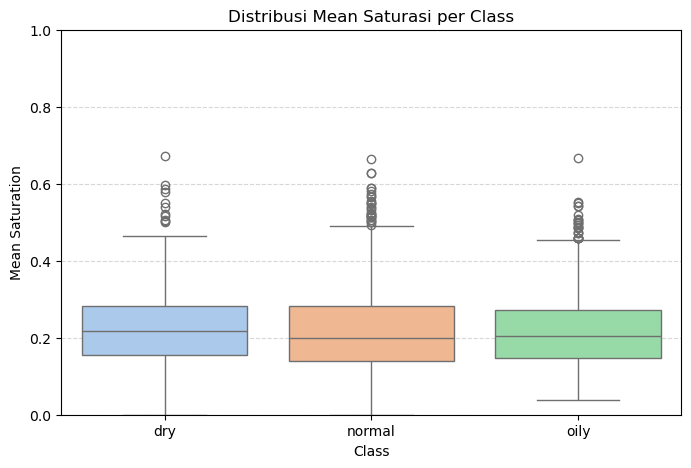

In [23]:

plt.figure(figsize=(8, 5))
sns.boxplot(data=df_saturation, x='Class_Name', y='Mean_Saturation', palette='pastel')
plt.title('Distribusi Mean Saturasi per Class')
plt.xlabel('Class')
plt.ylabel('Mean Saturation')
plt.ylim(0, 1)  # saturasi antara 0–1
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.show()

## Analisis Box Plot Saturasi Warna per Jenis Kulit

Gambar ini adalah box plot yang menunjukkan distribusi nilai **rata-rata saturasi (kejenuhan warna)** untuk tiga kelas jenis kulit: **kering (dry)**, **normal**, dan **berminyak (oily)**.

---

### Median Saturasi

- **Dry**: Median saturasi untuk kulit kering berada di sekitar **0.22 – 0.23**.
- **Normal**: Median saturasi untuk kulit normal sedikit lebih rendah, di sekitar **0.19 – 0.20**.
- **Oily**: Median saturasi untuk kulit berminyak berada di sekitar **0.20 – 0.21**.

> Median saturasi untuk ketiga kelas cukup dekat satu sama lain, meskipun kulit kering memiliki median yang sedikit lebih tinggi.

---

### Interquartile Range (IQR)

- **Dry**: IQR menunjukkan bahwa 50% data saturasi berada dalam rentang sekitar **0.15 hingga 0.28**.
- **Normal**: IQR sedikit lebih sempit, berkisar antara **0.12 hingga 0.27**.
- **Oily**: IQR serupa, sekitar **0.15 hingga 0.27**.

> Rentang IQR untuk ketiga kelas tidak menunjukkan perbedaan yang signifikan, artinya sebagian besar data saturasi rata-rata terdistribusi dalam rentang yang mirip.

---

### Penyebaran Data (Whiskers)

- Whiskers (garis vertikal dari kotak) menunjukkan rentang data di luar IQR, tidak termasuk outlier.
- Ketiga kelas menunjukkan penyebaran data yang **relatif mirip**.

---

### Outlier

- Ketiga kelas (**dry**, **normal**, **oily**) memiliki **outlier** yang cukup banyak di bagian atas.
- Beberapa gambar dalam setiap kelas menunjukkan **nilai saturasi yang sangat tinggi**, bahkan mencapai **0.7**.
- Hal ini menunjukkan adanya **gambar-gambar dengan kejenuhan warna yang jauh lebih tinggi** dibandingkan mayoritas data.

---


# Feature Engineering

## 1. model konfigurasi 

In [24]:
# 1. Konfigurasi
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 44
AUTOTUNE = tf.data.AUTOTUNE

## Konfigurasi Parameter Dataset

- **`IMG_SIZE = (224, 224)`**  
  Gambar akan diubah ukurannya menjadi 224×224 piksel. Ukuran standar untuk banyak model CNN.

- **`BATCH_SIZE = 32`**  
  Jumlah data yang diproses per batch saat training. Ukuran umum dan efisien.

- **`SEED = 44`**  
  Untuk memastikan hasil eksperimen bisa direproduksi secara konsisten.

- **`AUTOTUNE = tf.data.AUTOTUNE`**  
  TensorFlow otomatis menyesuaikan jumlah thread untuk pemrosesan data agar efisien.


## 2. Data Augmentasi dan Pre-processing


In [25]:
# Data augmentation untuk train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Flow from dataframe
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Img_Path',
    y_col='Class_Name',  # label dalam bentuk string
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # sparse akan mengubah string jadi int indeks secara otomatis
    shuffle=True,
    seed=SEED
)



Found 2206 validated image filenames belonging to 3 classes.


## 3. Pre-processing Hasil Augmentasi

In [26]:
# Data augmentation untuk train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

# Flow from dataframe
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Img_Path',
    y_col='Class_Name',  # label dalam bentuk string
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # sparse akan mengubah string jadi int indeks secara otomatis
    shuffle=True,
    seed=SEED
)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['Class_Name']),
    y=train_df['Class_Name']
)
class_weights = dict(enumerate(class_weights))


Found 2206 validated image filenames belonging to 3 classes.


## Proses Augmentasi dan Persiapan Data

### Augmentasi Data
`ImageDataGenerator` dikonfigurasi dengan berbagai teknik augmentasi untuk meningkatkan generalisasi model:

- `rescale=1./255`: Normalisasi piksel ke rentang 0–1.
- `rotation_range=20`, `zoom_range=0.2`, `width_shift_range=0.1`, `height_shift_range=0.1`: Transformasi geometris kecil agar model lebih tahan terhadap perubahan posisi dan orientasi.
- `horizontal_flip=True`: Membalik gambar secara horizontal, berguna untuk data simetris.
- `brightness_range=[0.8, 1.2]`: Variasi pencahayaan agar model lebih tangguh terhadap kondisi cahaya yang berbeda.

### Pemrosesan Data dari DataFrame
Menggunakan `flow_from_dataframe`:

- Memuat data dari kolom `Img_Path` (gambar) dan `Class_Name` (label).
- `class_mode='sparse'`: Label string otomatis dikonversi ke label numerik.
- `shuffle=True`: Menghindari model belajar urutan data.

### Penanganan Ketidakseimbangan Kelas
Menggunakan `compute_class_weight(class_weight='balanced', ...)`:

- Memberikan bobot lebih besar untuk kelas minoritas.
- Dikonversi ke `dict(enumerate(...))` agar kompatibel dengan TensorFlow/Keras.



In [27]:
val_datagen = ImageDataGenerator(rescale=1./255)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='Img_Path',
    y_col='Class_Name',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    seed=SEED
)


Found 473 validated image filenames belonging to 3 classes.


In [28]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Img_Path',
    y_col='Class_Name',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False,
    seed=SEED
)

Found 473 validated image filenames belonging to 3 classes.


## Validasi dan Uji Tanpa Augmentasi

### Tidak Ada Augmentasi pada Data Validasi dan Uji
- `val_datagen` dan `test_datagen` hanya menggunakan `rescale=1./255`.
- Tidak ada augmentasi seperti rotasi, zoom, atau flip.
- Penting untuk memastikan evaluasi model yang objektif pada data yang belum diubah.

### Konsistensi Parameter Generator
- `dataframe=val_df` dan `dataframe=test_df`: Data diambil dari DataFrame berbeda untuk validasi dan uji.
- `x_col='Img_Path'`, `y_col='Class_Name'`: Konsisten dengan data pelatihan.
- `target_size=IMG_SIZE`, `batch_size=BATCH_SIZE`: Ukuran gambar dan batch sama di semua set.
- `class_mode='sparse'`: Label dikodekan sebagai integer, bukan one-hot.
- `shuffle=False`: Diperlukan untuk menjaga urutan tetap, memudahkan analisis dan debugging.
- `seed=SEED`: Menjamin hasil yang konsisten dan dapat direproduksi.



# ANN Training (Sequential API/Functional API)

## vi.1. Model Definition

In [29]:
# Clear session & seed
SEED = 44
tf.keras.backend.clear_session()
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [30]:
# Arsitektur CNN
model = tf.keras.Sequential([

    # Deep Layer 1 - Input + Convolution Block
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Deep Layer 2
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    # Deep Layer 3
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),


    # Global Feature Pooling
    tf.keras.layers.GlobalAveragePooling2D(),


    # Fully Connected Layer 2 (128 neuron) + Dropout
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.0005)),
    tf.keras.layers.Dropout(0.3),

    # Output Layer - Softmax untuk 3 kelas
    tf.keras.layers.Dense(3, activation='softmax')
])

# Kompilasi model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0005),
    metrics=['accuracy']
)

# Ringkasan
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 112, 112, 64)     256       
 hNormalization)                                                 
                                                        

## Analisis Arsitektur Model CNN

Model CNN ini dibangun menggunakan praktik terbaik untuk mencegah overfitting dan meningkatkan performa.

---

### Struktur Arsitektur (Convolutional Base)

**Blok Konvolusi:**
- Pola: `Conv2D` → `BatchNormalization` → `MaxPooling2D`
- **Conv2D**: Mengekstraksi fitur spasial dari gambar.
- **BatchNormalization**: Menstabilkan dan mempercepat pelatihan.
- **MaxPooling2D**: Mengurangi dimensi spasial dan parameter model.

**Progresi Filter:**
- Jumlah filter meningkat: **32 → 64 → 128**
- Praktik umum untuk mempelajari fitur kompleks di lapisan lebih dalam.

**Konfigurasi tambahan:**
- `padding='same'`: Mempertahankan dimensi spasial.
- `activation='relu'`: Menghindari masalah vanishing gradient.

---

### Global Feature Pooling

**`GlobalAveragePooling2D`:**
- Mengganti `Flatten` untuk mengurangi parameter.
- Lebih efisien dan lebih tahan terhadap overfitting.
- Memperlakukan setiap fitur map sebagai fitur global.

---

### Lapisan Fully Connected (Dense)

- **`Dense(128, activation='relu', kernel_regularizer=l2(0.0005))`**  
  Menggunakan aktivasi ReLU dan regularisasi L2 untuk mencegah overfitting.
- **`Dropout(0.3)`**  
  Menonaktifkan 30% neuron selama pelatihan untuk meningkatkan generalisasi.

---

### Lapisan Output

- **`Dense(3, activation='softmax')`**  
  Untuk klasifikasi 3 kelas. Menghasilkan distribusi probabilitas antar kelas.

---

### Kompilasi Model

- **`loss='sparse_categorical_crossentropy'`**  
  Cocok untuk label kelas integer (bukan one-hot encoded).
- **`optimizer=Adam(learning_rate=0.0005)`**  
  Optimizer yang kuat dengan learning rate konservatif.
- **`metrics=['accuracy']`**  
  Metrik standar untuk klasifikasi multi-kelas.

---

### Potensi Perbaikan

- **Penyetelan Hyperparameter**:  
  `learning_rate`, `dropout`, dan `L2` dapat disesuaikan lebih lanjut.
- **Penambahan Kedalaman/Jumlah Filter**:  
  Jika dataset lebih kompleks.
- **Transfer Learning**:  
  Pertimbangkan model pre-trained seperti ResNet untuk hasil lebih baik.

---

### Analisis Tambahan

- **`model.summary()`**  
  Memberikan informasi parameter dan struktur layer.
- **`tf.keras.utils.plot_model(model, show_shapes=True)`**  
  Visualisasi grafis alur data dan dimensi output antar layer.

---


In [31]:
# --- DEFINISI CALLBACKS ---
earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=15, # Ditingkatkan dari 5 ke 15 untuk memberi lebih banyak waktu pada model yang kompleks
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr = 1e-6,
    verbose=1
)

## Callback: ReduceLROnPlateau dan EarlyStopping

###  ReduceLROnPlateau
- Secara otomatis **menurunkan learning rate** saat performa model stagnan (tidak ada peningkatan pada metrik validasi dalam beberapa epoch).
- Tujuan: Memberikan kesempatan bagi model untuk belajar lebih halus di sekitar minima loss.
- Cocok digunakan saat training mulai melambat agar model tetap bisa berkembang.

###  EarlyStopping
- **Menghentikan pelatihan lebih awal** jika tidak ada peningkatan signifikan dalam validasi loss setelah sejumlah epoch (patience).
- Mencegah **pemborosan komputasi** dan **overfitting**.
- Parameter `restore_best_weights=True` memastikan bobot terbaik (bukan terakhir) disimpan.

###  Kolaborasi Keduanya
- `ReduceLROnPlateau` mencoba menurunkan learning rate lebih dulu saat kemajuan melambat.
- Jika penurunan learning rate tidak berhasil (tidak ada peningkatan setelah beberapa percobaan), `EarlyStopping` akan mengambil alih untuk menghentikan pelatihan.
- Kombinasi ini memastikan **pelatihan efisien, stabil, dan tidak berlarut-larut**.



## vi.2. Model Training

In [32]:

K.clear_session()

In [33]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[earlystopping, reduce_lr],
    class_weight=class_weights
)


Epoch 1/30
69/69 [==============================] - 30s 362ms/step - loss: 1.2047 - accuracy: 0.3554 - val_loss: 1.1891 - val_accuracy: 0.3087 - lr: 5.0000e-04
Epoch 2/30
69/69 [==============================] - 30s 432ms/step - loss: 1.1596 - accuracy: 0.3840 - val_loss: 1.2935 - val_accuracy: 0.2431 - lr: 5.0000e-04
Epoch 3/30
69/69 [==============================] - 27s 387ms/step - loss: 1.1531 - accuracy: 0.3858 - val_loss: 1.1895 - val_accuracy: 0.3256 - lr: 5.0000e-04
Epoch 4/30
69/69 [==============================] - ETA: 0s - loss: 1.1504 - accuracy: 0.3935
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
69/69 [==============================] - 26s 383ms/step - loss: 1.1504 - accuracy: 0.3935 - val_loss: 1.2627 - val_accuracy: 0.2685 - lr: 5.0000e-04
Epoch 5/30
69/69 [==============================] - 26s 375ms/step - loss: 1.1259 - accuracy: 0.3994 - val_loss: 1.2119 - val_accuracy: 0.3066 - lr: 1.0000e-04
Epoch 6/30
69/69 [======================

## vi.3. Model Evaluation

### Visualisasi Accuracy vs Validation Accuracy & Loss vs Validation Loss

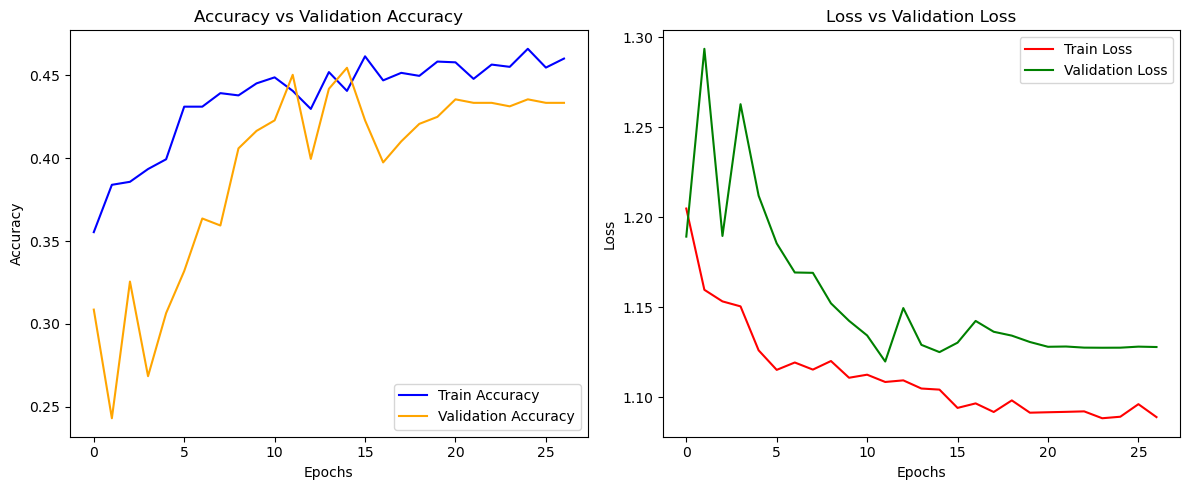

In [34]:


def plot_training_vs_validation(history):
    epochs_range = range(len(history.history['loss']))

    plt.figure(figsize=(12, 5))

    # Accuracy vs Validation Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['accuracy'], label='Train Accuracy', color='blue')
    plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy', color='orange')
    plt.title('Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss vs Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['loss'], label='Train Loss', color='red')
    plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss', color='green')
    plt.title('Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Panggil fungsinya
plot_training_vs_validation(history)


## Insight: Overfitting dan Evaluasi Model

### Overfitting Terlihat
- Train Loss terus turun, val_loss stagnan atau naik → jarak membesar.
- Train Accuracy naik >45%, val_accuracy stagnan di 40–43%.

### Kinerja Belum Optimal
- Akurasi validasi hanya sekitar 45% (sedikit di atas baseline 33.3%).

---

## Implikasi
- Model sulit generalisasi, hanya menghafal data latih.
- Masih banyak ruang untuk perbaikan performa.

---

## Solusi dan Perbaikan

### 1. Augmentasi Data
- Sudah diterapkan, tapi bisa diperkuat:
  - Tambah `rotation_range`, `zoom_range`, `brightness_range`.
  - Tambahkan `vertical_flip`, `shear_range` jika relevan.

### 2. Arsitektur Model
- Sudah ada Dropout dan L2.
- Tingkatkan regularisasi:
  - Dropout 0.4–0.5, L2: 0.001 atau lebih tinggi.
  - Tambahkan `kernel_regularizer` pada Conv2D jika perlu.
- Kurangi kompleksitas:
  - Kurangi filter, layer, dan neuron Dense.
- Gunakan transfer learning:
  - Coba MobileNetV2, EfficientNet, atau ResNet.

### 3. Learning Rate
- Awal: 0.0005 → bisa dicoba 0.0001 atau 0.0002.
- Gunakan Learning Rate Finder untuk tuning otomatis.

### 4. Callbacks
- EarlyStopping dan ReduceLROnPlateau sudah tepat.
- Jika training terlalu lama, kurangi `patience`.

### 5. Dataset
- Data relatif sedikit untuk 3 kelas.
- Solusi:
  - Tambah data jika bisa.
  - Gunakan validasi silang (K-Fold).
  - Periksa kualitas data dan distribusi kelas.

---

## Rekomendasi Prioritas

### Prioritas Tinggi
- Terapkan transfer learning.
- Tingkatkan regularisasi.
- Tambah data jika tersedia.

### Prioritas Menengah
- Perluas augmentasi.
- Optimalkan learning rate.


### classification_report

In [35]:

# Ambil prediksi
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

15/15 [==============================] - 2s 151ms/step
              precision    recall  f1-score   support

         dry       0.34      0.27      0.30       114
      normal       0.51      0.52      0.51       191
        oily       0.44      0.49      0.46       168

    accuracy                           0.45       473
   macro avg       0.43      0.43      0.43       473
weighted avg       0.44      0.45      0.45       473



## Implikasi Umum

- Model belum andal, terutama untuk kelas **'dry'**.
- Terjadi **bias ke kelas mayoritas ('normal')**.
- Tanda overfitting meski sudah ada regularisasi.

---

## Solusi Fokus Performa Kelas

### 1. Ketidakseimbangan Kelas

- **Oversampling**: Gandakan kelas minoritas atau gunakan **SMOTE**.
- **Undersampling**: Kurangi kelas mayoritas (hati-hati).
- **Gabungan**: Kombinasi over + under sampling.

### 2. Loss & Metrik

- **Weighted Cross-Entropy**: Gunakan `class_weight` saat training.
- **Focal Loss**: Cocok untuk kelas minoritas, butuh custom loss.

### 3. Data & Augmentasi

- Tinjau ulang gambar kelas 'dry'.
- Tambahkan **preprocessing** (kontras, penajaman).
- Gunakan **augmentasi khusus** untuk kelas 'dry'.

### 4. Ensemble

- Gabungkan beberapa model, rata-rata hasil prediksinya.

---

## Rangkuman

| Area               | Tindakan                                           |
|--------------------|----------------------------------------------------|
| Ketidakseimbangan  | Oversampling, class_weight, focal loss             |
| Kelas 'dry'        | Analisis data & augmentasi khusus                  |
| Generalisasi       | Ensemble & revisi preprocessing                    |


### ConfusionMatrixDisplay

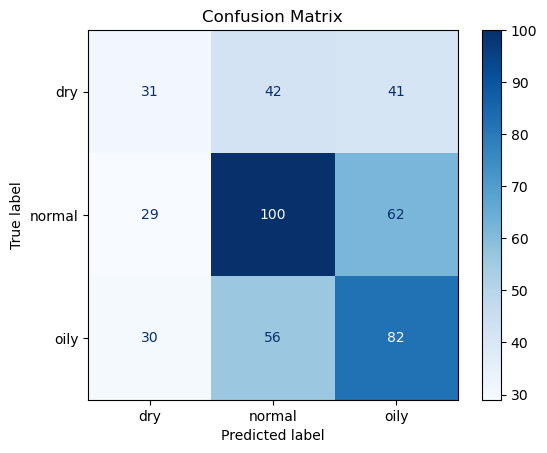

In [36]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

## Kesimpulan Utama dari Confusion Matrix

### 1. Overfitting & Generalisasi Buruk
- Model terlalu menghafal data train.
- Gagal menangkap fitur umum antar kelas.

### 2. Masalah pada Kelas 'dry'
- **Recall & Precision terendah.**
- Banyak sampel 'dry' salah diprediksi sebagai 'normal' atau 'oily'.

### 3. Ambiguitas antara 'normal' vs 'oily'
- Prediksi silang tinggi:  
  - 62 sampel 'normal' → 'oily'  
  - 56 sampel 'oily' → 'normal'
- Fitur model belum cukup membedakan kedua kelas ini.

### 4. Bias terhadap Kelas 'normal'
- Model terlalu sering memprediksi 'normal'.
- Tanda bias ke kelas mayoritas.

# ANN Improvement (Sequential API/Functional API)

## vii.1. Model Definition

In [37]:
# 1. Clear session dan seed
tf.keras.backend.clear_session()
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [38]:
# 1. Jumlah kelas
num_classes = len(os.listdir(train_path))



# 2. Input layer
inputs = Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

# 3. Backbone
resnet_base = ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=inputs
)

# 4. Fine-tuning
for layer in resnet_base.layers[:100]:
    layer.trainable = False
for layer in resnet_base.layers[100:]:
    layer.trainable = True

# 5. Tambahan layer (Head Klasifikasi yang Diperbarui)
x = resnet_base.output
x = GlobalAveragePooling2D()(x)

# First Dense block
x = BatchNormalization()(x) 
x = Dense(64, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(0.0005))(x)
x = BatchNormalization()(x) 
x = Dropout(0.3)(x) 


outputs = Dense(num_classes, activation='softmax')(x)


# 6. Final model
improved_model = Model(inputs=inputs, outputs=outputs)

# 7. Compile
improved_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# 8. Summary
improved_model.summary()
tf.keras.utils.plot_model(improved_model, show_shapes=True)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

## Transfer Learning dengan ResNet50

### Backbone
- `ResNet50(...)`: Arsitektur kuat, pretrained di ImageNet.
- `include_top=False`: Lapisan klasifikasi asli dihapus.
- `weights='imagenet'`: Gunakan bobot pretrained.
- `input_tensor=inputs`: Input kustom dari model.

### Fine-Tuning
- `layer.trainable = False (0–99)`: Bekukan lapisan awal (fitur dasar).
- `layer.trainable = True (100–end)`: Fine-tune lapisan atas (fitur spesifik).

### Classification Head
- `GlobalAveragePooling2D()`: Reduksi dimensi, cegah overfitting.
- `BatchNormalization()`: Stabilkan aktivasi.
- `Dense(64, relu, he_uniform, l2)`: Lapisan dense lebih ringan (dari 128 → 64).
- `Dropout(0.3)`: Regularisasi tambahan.
- `Dense(num_classes, softmax)`: Output 3 kelas.

### Kompilasi
- `loss='sparse_categorical_crossentropy'`: Cocok untuk label integer.
- `optimizer=Adam(1e-4)`: Learning rate kecil → stabilkan fine-tuning.

## Implikasi Positif
- **Akurasi naik**: Berkat fitur pretrained.
- **Overfitting menurun**: Parameter lebih sedikit dilatih.
- **Konvergensi cepat**: Tidak mulai dari nol.
- **Model lebih robust**: Fitur lebih general dan kuat.

## Pertimbangan Tambahan
- Jumlah lapisan dibekukan dapat disesuaikan.
- Layer-wise learning rate (lanjutan).
- Masalah imbalance kelas 'dry' tetap perlu ditangani lebih agresif.


## vii.2. Model Training

In [39]:
K.clear_session()

In [40]:
# --- DEFINISI CALLBACKS ---
earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=15, # Ditingkatkan dari 5 ke 15 untuk memberi lebih banyak waktu pada model yang kompleks
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr = 1e-6,
    verbose=1
)

# Training
history_improved = improved_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=[earlystopping, reduce_lr],
    class_weight=class_weights  # opsional kalau kelas tidak seimbang
)

Epoch 1/20
69/69 [==============================] - 32s 393ms/step - loss: 1.6982 - accuracy: 0.3386 - val_loss: 1.3379 - val_accuracy: 0.3531 - lr: 1.0000e-04
Epoch 2/20
69/69 [==============================] - 27s 387ms/step - loss: 1.5284 - accuracy: 0.3495 - val_loss: 1.2096 - val_accuracy: 0.2896 - lr: 1.0000e-04
Epoch 3/20
69/69 [==============================] - 27s 388ms/step - loss: 1.4621 - accuracy: 0.3368 - val_loss: 1.2383 - val_accuracy: 0.2875 - lr: 1.0000e-04
Epoch 4/20
69/69 [==============================] - 26s 381ms/step - loss: 1.3869 - accuracy: 0.3518 - val_loss: 1.2973 - val_accuracy: 0.2748 - lr: 1.0000e-04
Epoch 5/20
69/69 [==============================] - 27s 390ms/step - loss: 1.3735 - accuracy: 0.3341 - val_loss: 1.2090 - val_accuracy: 0.3192 - lr: 1.0000e-04
Epoch 6/20
69/69 [==============================] - 27s 391ms/step - loss: 1.3394 - accuracy: 0.3654 - val_loss: 1.1505 - val_accuracy: 0.3911 - lr: 1.0000e-04
Epoch 7/20
69/69 [======================

## vii.3. Model Evaluation

### Visualisasi Accuracy vs Validation Accuracy & Loss vs Validation Loss

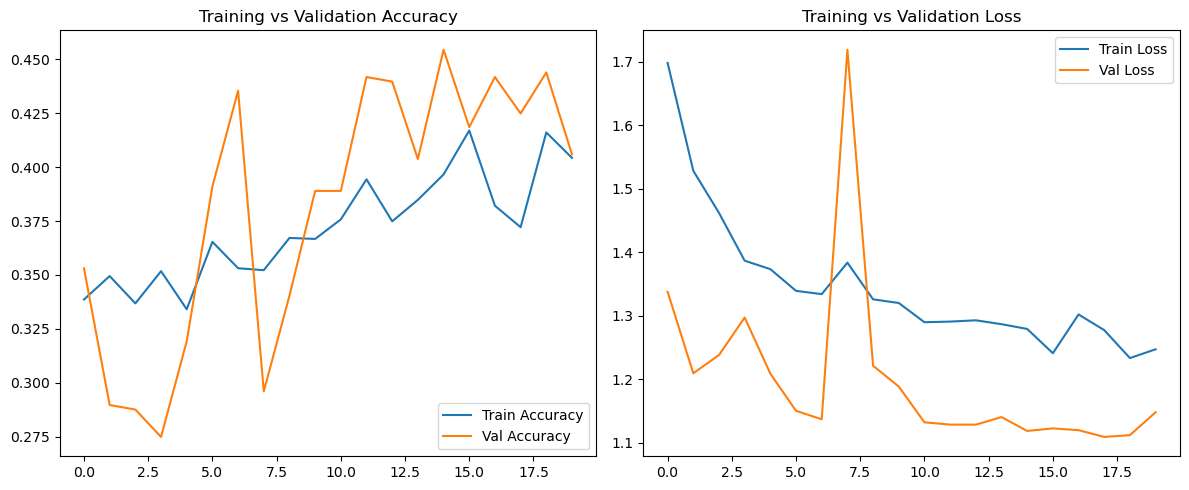

In [41]:
# Visualisasi Accuracy & Loss
acc = history_improved.history['accuracy']
val_acc = history_improved.history['val_accuracy']
loss = history_improved.history['loss']
val_loss = history_improved.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Accuracy')
plt.plot(epochs_range, val_acc, label='Val Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

# Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

plt.tight_layout()
plt.show()

## Analisis Overfitting & Ketidakstabilan Konvergensi

### Potensi Penyebab

- **Model Terlalu Kompleks**  
  CNN custom dari nol butuh data besar. Jika data terbatas, model cenderung overfit.

- **Learning Rate Terlalu Tinggi**  
  Model sulit menetap di titik optimal → fluktuasi besar di val_loss/val_acc.

- **Validasi Tidak Representatif**  
  Set validasi berbeda distribusi → hasil tidak stabil.

- **Batch Size Tidak Tepat**  
  - Terlalu kecil → gradien berisik.  
  - Terlalu besar → terjebak local minima.

---

## Solusi yang Disarankan

### 1. Gunakan Transfer Learning
- Prioritaskan ResNet50 dengan fine-tuning jika belum diterapkan.

### 2. Optimasi Learning Rate
- Turunkan ke `1e-4` atau `5e-5`.
- Tambah `patience` ReduceLROnPlateau → 5–7.
- Pertimbangkan scheduler lain: `CosineAnnealing`, `OneCycleLR`.

### 3. Tingkatkan Regularisasi
- Tambah `Dropout` → dari 0.3 ke 0.4/0.5.
- Naikkan `l2` → dari 0.0005 ke 0.001 atau 0.005.
- Tambah `Dropout`/`kernel_regularizer` pada Conv2D (jika tanpa pretrained).

### 4. Perbaiki Augmentasi
- Tambah `RandomCrop`, `RandomBrightness`, dll.
- Sesuaikan dengan variasi alami dataset.

### 5. Coba Batch Size Berbeda
- Eksperimen ukuran batch: kecil → eksplorasi, besar → stabilisasi.

### 6. Gunakan Cross-Validation
- K-fold cross-validation untuk hasil evaluasi yang lebih andal.


### classification_report

In [42]:
# Prediksi data validasi
val_gen.reset()
y_pred_probs = improved_model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes
class_labels = list(val_gen.class_indices.keys())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

15/15 [==============================] - 3s 152ms/step
Classification Report:
              precision    recall  f1-score   support

         dry       0.30      0.82      0.44       114
      normal       0.62      0.23      0.33       191
        oily       0.63      0.33      0.43       168

    accuracy                           0.41       473
   macro avg       0.52      0.46      0.40       473
weighted avg       0.55      0.41      0.39       473



## Masalah Ketidakseimbangan Precision vs Recall

### Ringkasan Masalah
- Model terlalu sering memprediksi **'dry'** → high recall, low precision.
- Model gagal mengenali **'normal'** dan **'oily'** → low recall.
- Akurasi keseluruhan rendah karena distribusi prediksi tidak seimbang.

---

## Solusi yang Disarankan

### 1. Penyesuaian Bobot Kelas
- Hindari `class_weight='balanced'` yang terlalu agresif.
- Beri bobot manual, misalnya:
  - `'dry'`: kurangi jadi 0.8–0.9 dari nilai balanced.
  - `'normal'`, `'oily'`: tingkatkan sedikit bobotnya.

### 2. Threshold Tuning
- Ubah ambang klasifikasi default softmax.
- Tinggikan ambang untuk kelas `'dry'` → kurangi false positives.

### 3. Gunakan Transfer Learning
- Terapkan ResNet50 (jika belum).  
  Memberikan fitur yang lebih diskriminatif → kurangi bias.

### 4. Tingkatkan Augmentasi
- Tambah intensitas augmentasi (rotasi, zoom, brightness).
- Tujuannya: kurangi overfitting.

### 5. Analisis Kesalahan (Error Analysis)
- Lihat gambar:
  - `'normal'/'oily'` → salah sebagai `'dry'`.
  - `'dry'` → tidak dikenali (false negative).
  - `'normal'` ↔ `'oily'` → tertukar.

### 6. Tuning Hyperparameter
- Turunkan learning rate (terutama saat fine-tuning).
- Sesuaikan regulasi:
  - Kurangi Dropout atau L2 jika model terlalu terkekang.


### ConfusionMatrixDisplay

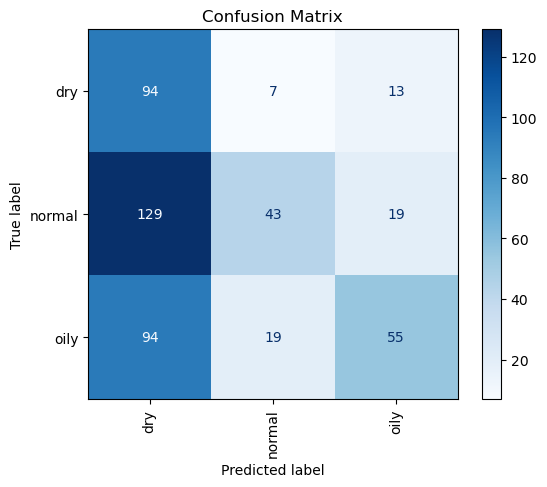

In [43]:
# Confusion Matrix Display
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    display_labels=class_labels,
    cmap='Blues',
    xticks_rotation='vertical'
)
plt.title("Confusion Matrix")
plt.show()

## Persiapan Data

### Augmentasi (Training)
- `train_datagen` sudah optimal: rotasi, zoom, flip, brightness.
- Membantu generalisasi dan mengurangi overfitting.

### Penanganan Ketidakseimbangan
- `class_weights='balanced'` digunakan.
- Kelas minoritas: `'dry'` (114 sampel).
- Strategi ini tepat, tetapi hasilnya perlu dievaluasi ulang.

### Validasi dan Uji
- `rescale=1./255`, `shuffle=False` digunakan.
- Konfigurasi benar untuk evaluasi yang stabil.
- Total: 473 gambar per set.

---

## Evaluasi dari Confusion Matrix

### Kelas 'dry' (114 sampel)
- Recall: 94/114 ≈ 0.82 (tinggi)
- Precision: 94/317 ≈ 0.30 (rendah)
- Model terlalu sering memprediksi 'dry'.

### Kelas 'normal' (191 sampel)
- Recall: 43/191 ≈ 0.23 (sangat rendah)
- Precision: 43/69 ≈ 0.62 (cukup baik)
- Banyak yang salah diklasifikasi sebagai 'dry'.

### Kelas 'oily' (168 sampel)
- Recall: 55/168 ≈ 0.33 (rendah)
- Precision: 55/87 ≈ 0.63 (cukup baik)
- Masih sering salah diklasifikasi sebagai 'dry'.

### Akurasi Total
- 192/473 ≈ 41%

---

## Rekomendasi Perbaikan

### 1. Penyesuaian class_weight
- Kurangi bobot 'dry' (misalnya 0.8 dari nilai balanced).
- Tambah bobot 'normal' dan 'oily'.
- Tujuan: mengurangi bias ke 'dry'.

### 2. Analisis Kesalahan
- Tinjau gambar:
  - False positives 'dry': apakah visualnya menyerupai 'dry'?
  - False negatives 'normal' dan 'oily': kenapa gagal dikenali?

### 3. Threshold Tuning
- Ubah ambang klasifikasi untuk 'dry' (misal: minimal 0.6).
- Hindari prediksi 'dry' jika probabilitasnya rendah.

### 4. Tinjau Arsitektur dan Regularisasi
- Jika sudah pakai ResNet50: sudah tepat.
- Jika overfitting tetap terjadi:
  - Tambah dropout atau L2.
  - Turunkan learning rate.

### 5. Audit Kualitas Data
- Pastikan label tidak salah dan gambar tidak bermasalah.
- Kesalahan kecil bisa berdampak signifikan.

---

## Kesimpulan
Permasalahan utama ada pada bias berlebihan terhadap kelas 'dry'. Fokuskan perbaikan pada penyetelan bobot, threshold, dan analisis kesalahan untuk meningkatkan keseimbangan precision dan recall.


# Model Saving

In [45]:
improved_model.save('improved_model.keras')

# Model Inference

inference dilakukan di **P2G7_Nugroho_wicaksono_inference.ipynb**


# Pengambilan Kesimpulan